In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
figsize = (12, 8)

# Load the data
df_raw = pd.read_csv('playbyplayfinal.csv')

# Remove rows where teamId is 0
df = df_raw[df_raw['teamId'] != 0]

# Quick statistics
print("Dataset Info:")
print("-" * 50)
print(f"Rows: {len(df)}")
print(f"Columns: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes.value_counts())

print("\nBasic Statistics:")
print(df.describe())

Dataset Info:
--------------------------------------------------
Rows: 37969
Columns: 24
Memory usage: 20.45 MB

Column Names:
['gameId', 'clock', 'period', 'teamId', 'teamTricode', 'personId', 'playerName', 'xLegacy', 'yLegacy', 'shotDistance', 'shotResult', 'isFieldGoal', 'scoreHome', 'scoreAway', 'pointsTotal', 'location', 'actionType', 'subType', 'shotValue', 'actionId', 'SEASON', 'period_seconds_remaining', 'sec_elapsed_in_period', 'sec_elapsed_game']

Data Types:
int64      11
str         8
float64     5
Name: count, dtype: int64

Basic Statistics:
             gameId        period        teamId      personId       xLegacy  \
count  3.796900e+04  37969.000000  3.796900e+04  3.796900e+04  37969.000000   
mean   2.220004e+07      2.522189  1.610613e+09  1.205039e+06     -0.768021   
std    2.347048e+01      1.140304  8.558998e+00  6.541788e+05     69.116100   
min    2.220000e+07      1.000000  1.610613e+09  2.544000e+03   -248.000000   
25%    2.220002e+07      2.000000  1.610613e

In [20]:
shot_result_counts = df_filt_game['shotResult'].value_counts()
print("Shot Result Value Counts:")
print("-" * 30)
print(shot_result_counts)

gameId_unique = df['gameId'].unique()
print("Unique Game Id Value Counts:")
print("-" * 30)
print(len(gameId_unique))

Shot Result Value Counts:
------------------------------
shotResult
Made      86
Missed    76
Name: count, dtype: int64
Unique Game Id Value Counts:
------------------------------
82


In [8]:
df_filt_game = df[df['gameId'] == 22200001] 
df_filt_game

,gameId,clock,period,teamId,teamTricode,personId,playerName,xLegacy,yLegacy,shotDistance,...,pointsTotal,location,actionType,subType,shotValue,actionId,SEASON,period_seconds_remaining,sec_elapsed_in_period,sec_elapsed_game
1,22200001,PT12M00.00S,1,1610612738,BOS,201143,Horford,0,0,0,...,0,h,Jump Ball,NaN,0,2,2022-23,720.0,0.0,0.0
2,22200001,PT11M38.00S,1,1610612755,PHI,203954,Embiid,-118,50,13,...,0,v,Missed Shot,Turnaround Fadeaway shot,2,3,2022-23,698.0,22.0,22.0
3,22200001,PT11M38.00S,1,1610612738,BOS,1627759,Brown,0,0,0,...,0,h,NaN,NaN,2,4,2022-23,698.0,22.0,22.0
4,22200001,PT11M35.00S,1,1610612755,PHI,200782,Tucker,0,0,0,...,0,v,Rebound,Unknown,0,5,2022-23,695.0,25.0,25.0
5,22200001,PT11M35.00S,1,1610612755,PHI,200782,Tucker,0,0,0,...,0,v,Turnover,Out of Bounds Lost Ball Turnover,0,6,2022-23,695.0,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,22200001,PT00M32.10S,4,1610612738,BOS,1627759,Brown,0,0,0,...,0,h,Turnover,Lost Ball,0,463,2022-23,32.1,687.9,2847.9
463,22200001,PT00M32.10S,4,1610612755,PHI,202699,Harris,0,0,0,...,0,v,NaN,NaN,0,464,2022-23,32.1,687.9,2847.9
464,22200001,PT00M29.80S,4,1610612755,PHI,202699,Harris,0,5,1,...,243,v,Made Shot,Running Dunk Shot,2,465,2022-23,29.8,690.2,2850.2
465,22200001,PT00M06.90S,4,1610612738,BOS,201143,Horford,131,218,25,...,0,h,Missed Shot,Jump Shot,3,466,2022-23,6.9,713.1,2873.1


In [15]:




# Create derived features needed for analysis
def create_game_features(df):
    """Create additional features for game-level analysis"""
    
    # Create a copy to avoid warnings
    df_copy = df.copy()
    df_copy['points_from_makes'] = np.where(df['shotResult'] == 'Made', df['shotValue'], 0)
    
    # Game-level aggregations
    game_stats = df_copy.groupby(['gameId', 'teamId']).agg({
        'pointsTotal': 'max',  # Final score
        'shotResult': lambda x: (x == 'Made').sum(),  # Made shots
        'isFieldGoal': 'sum',  # Total field goal attempts
        'shotValue': 'sum',  # Total points from shots
        'period': 'max',  # Max period (games can go to OT)
    }).rename(columns={
        'pointsTotal': 'final_score',
        'shotResult': 'made_shots',
        'isFieldGoal': 'fg_attempts',
        'shotValue': 'total_points_from_shots',
        'period': 'max_period'
    })
    
    # Calculate field goal percentage
    game_stats['fg_percentage'] = (game_stats['made_shots'] / game_stats['fg_attempts'] * 100)
    
    # Determine winner
    game_winners = game_stats.groupby('gameId')['final_score'].idxmax()
    game_stats['is_winner'] = 0
    game_stats.loc[game_winners, 'is_winner'] = 1
    
    # Quarter-level performance
    quarter_stats = df_copy.groupby(['gameId', 'teamId', 'period']).agg({
        'points_from_makes': 'sum',
        'shotResult': lambda x: (x == 'Made').sum(),  # Made shots in quarter
        'isFieldGoal': 'count',  # Total plays in quarter
    }).rename(columns={
        'points_from_makes': 'quarter_points',
        'shotResult': 'quarter_made_shots',
        'isFieldGoal': 'quarter_plays'
    })
    
    # Pivot to get quarter-by-quarter points
    quarter_points_pivot = quarter_stats['quarter_points'].unstack(fill_value=0)
    quarter_points_pivot.columns = [f'Q{int(col)}_points' for col in quarter_points_pivot.columns]
    
    # Calculate momentum metrics
    if len(quarter_points_pivot.columns) >= 4:
        quarter_points_pivot['first_half_points'] = quarter_points_pivot['Q1_points'] + quarter_points_pivot['Q2_points']
        quarter_points_pivot['second_half_points'] = quarter_points_pivot['Q3_points'] + quarter_points_pivot.get('Q4_points', 0)
        quarter_points_pivot['h1h2_momentum_change'] = quarter_points_pivot['second_half_points'] - quarter_points_pivot['first_half_points']
        quarter_points_pivot['q1q2_momentum_change'] = quarter_points_pivot['Q2_points'] - quarter_points_pivot['Q1_points']
        quarter_points_pivot['q2q3_momentum_change'] = quarter_points_pivot['Q3_points'] - quarter_points_pivot['Q2_points']
        quarter_points_pivot['q3q4_momentum_change'] = quarter_points_pivot['Q4_points'] - quarter_points_pivot['Q3_points']
        quarter_points_pivot['consistency'] = quarter_points_pivot[['Q1_points', 'Q2_points', 'Q3_points', 'Q4_points']].std(axis=1)
    
    # Merge all features
    game_stats = game_stats.join(quarter_points_pivot)
    
    return game_stats

# Create game-level dataset
game_df = create_game_features(df)
print("Game-level dataset shape:", game_df.shape)
print("\nFirst few rows:")
print(game_df.head())



Game-level dataset shape: (164, 19)

First few rows:
                     final_score  made_shots  fg_attempts  \
gameId   teamId                                             
22200001 1610612738          236          46           82   
         1610612755          243          40           80   
22200002 1610612744          227          45           99   
         1610612747          232          40           94   
22200003 1610612753          220          42           86   

                     total_points_from_shots  max_period  fg_percentage  \
gameId   teamId                                                           
22200001 1610612738                      205           4      56.097561   
         1610612755                      200           4      50.000000   
22200002 1610612744                      251           4      45.454545   
         1610612747                      237           4      42.553191   
22200003 1610612753                      212           4      48.8372

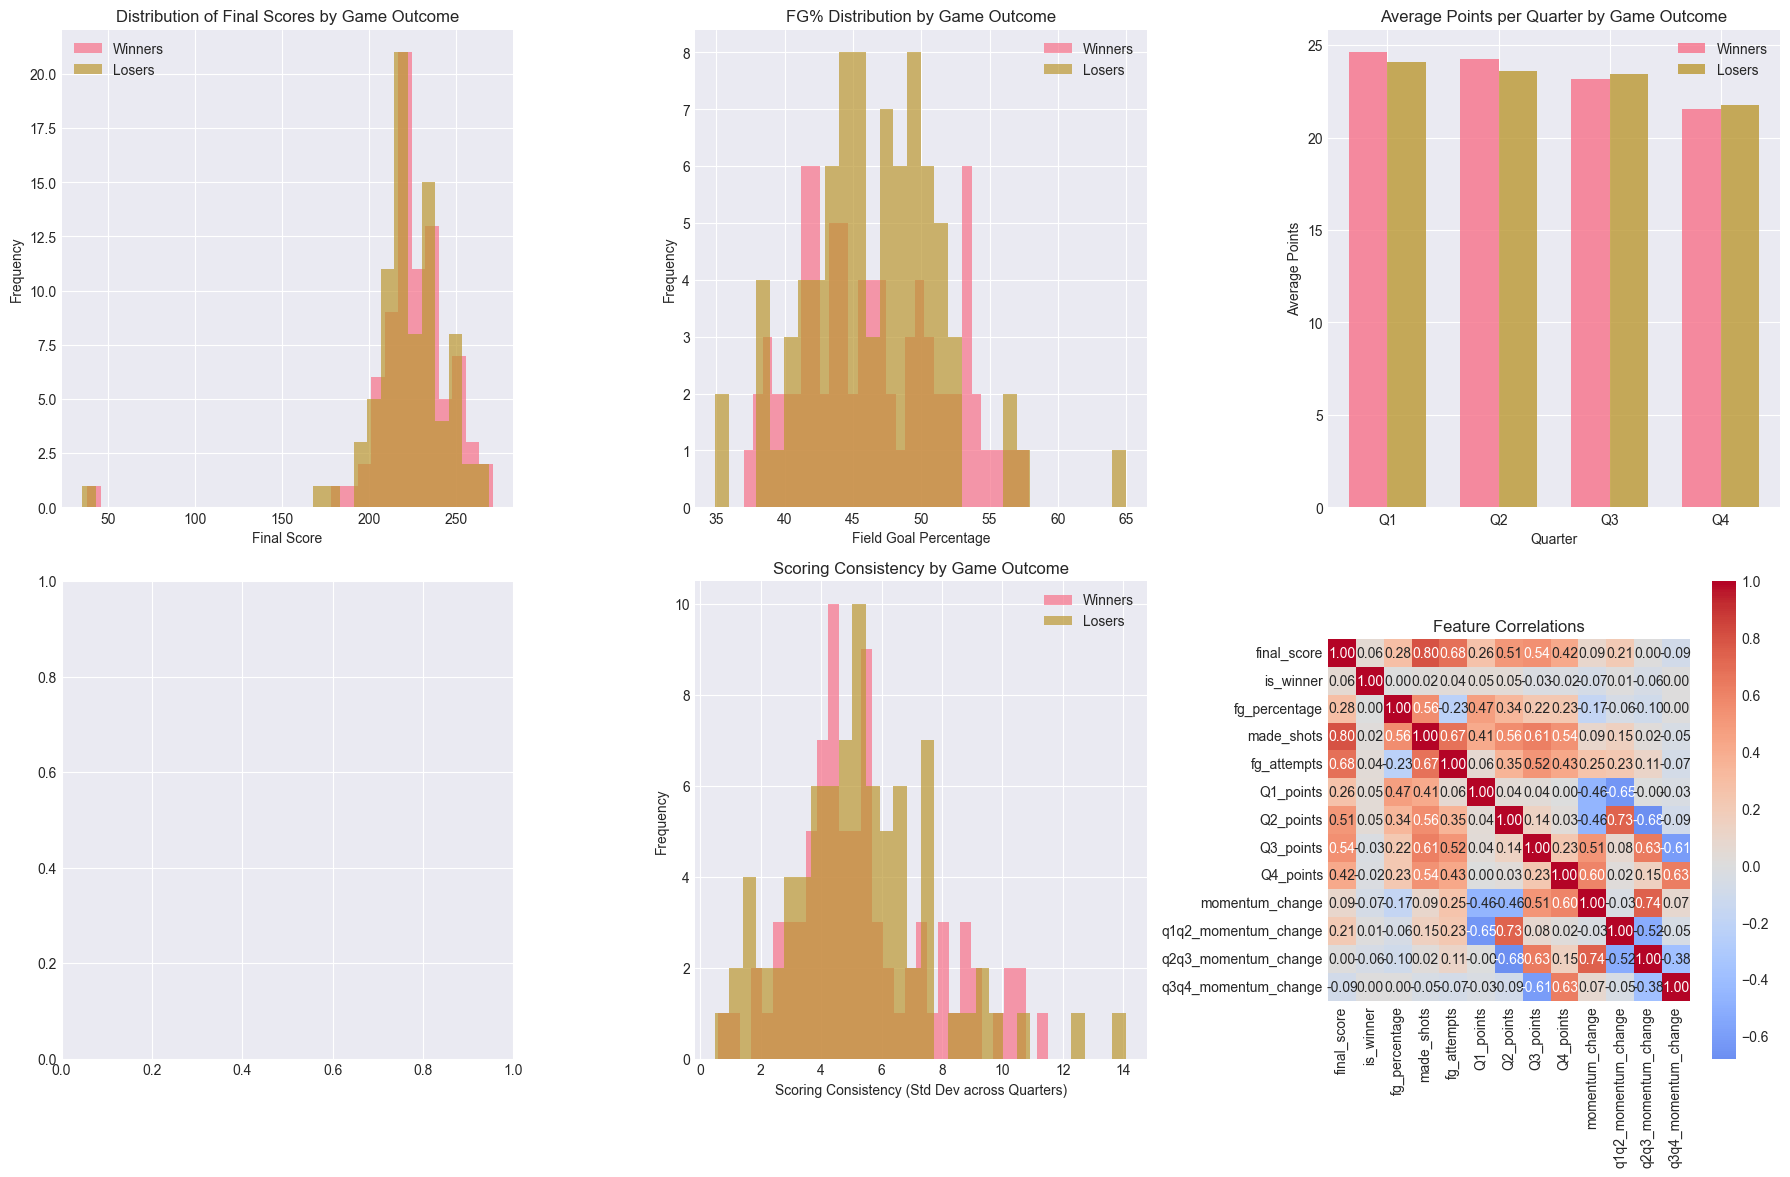

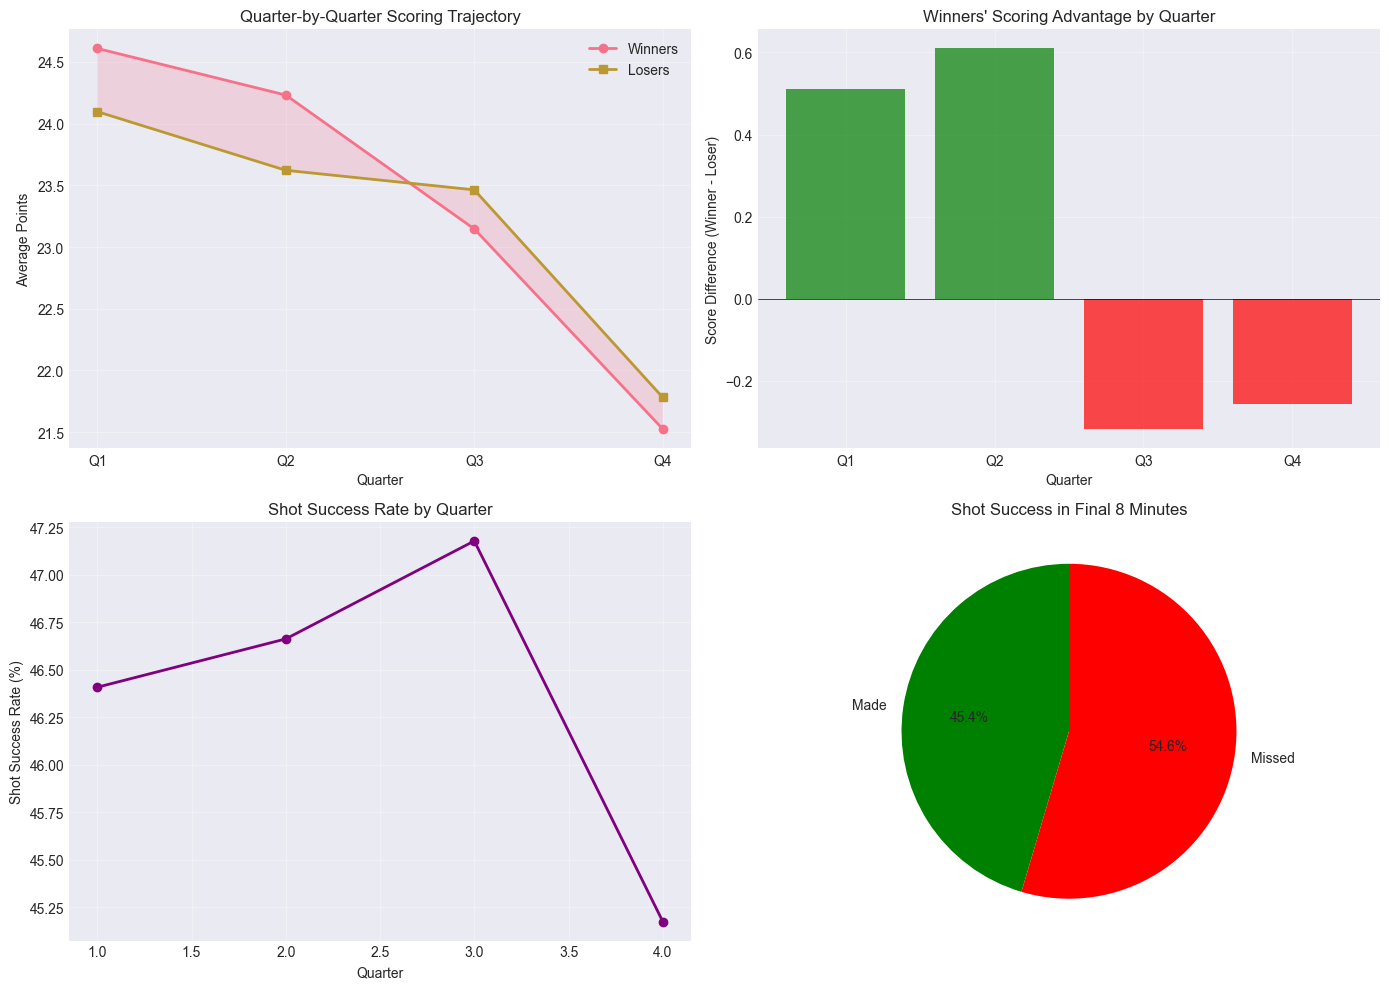


STATISTICAL SUMMARY BY GAME OUTCOME

Winners Statistics (Key Metrics):
----------------------------------------
final_score:
  Mean (Winners): 225.12
  Mean (Losers):  221.99
  Difference:     3.13

fg_percentage:
  Mean (Winners): 46.48
  Mean (Losers):  46.47
  Difference:     0.01

Q1_points:
  Mean (Winners): 24.61
  Mean (Losers):  24.10
  Difference:     0.51

Q2_points:
  Mean (Winners): 24.23
  Mean (Losers):  23.62
  Difference:     0.61

Q3_points:
  Mean (Winners): 23.15
  Mean (Losers):  23.46
  Difference:     -0.32

Q4_points:
  Mean (Winners): 21.52
  Mean (Losers):  21.78
  Difference:     -0.26


STATISTICAL TESTS FOR QUARTER-LEVEL DIFFERENCES

Quarter 1:
  T-statistic: 0.5808
  P-value: 0.5622
  No significant difference at α=0.05

Quarter 2:
  T-statistic: 0.6166
  P-value: 0.5384
  No significant difference at α=0.05

Quarter 3:
  T-statistic: -0.3383
  P-value: 0.7356
  No significant difference at α=0.05

Quarter 4:
  T-statistic: -0.2693
  P-value: 0.7880
  No s

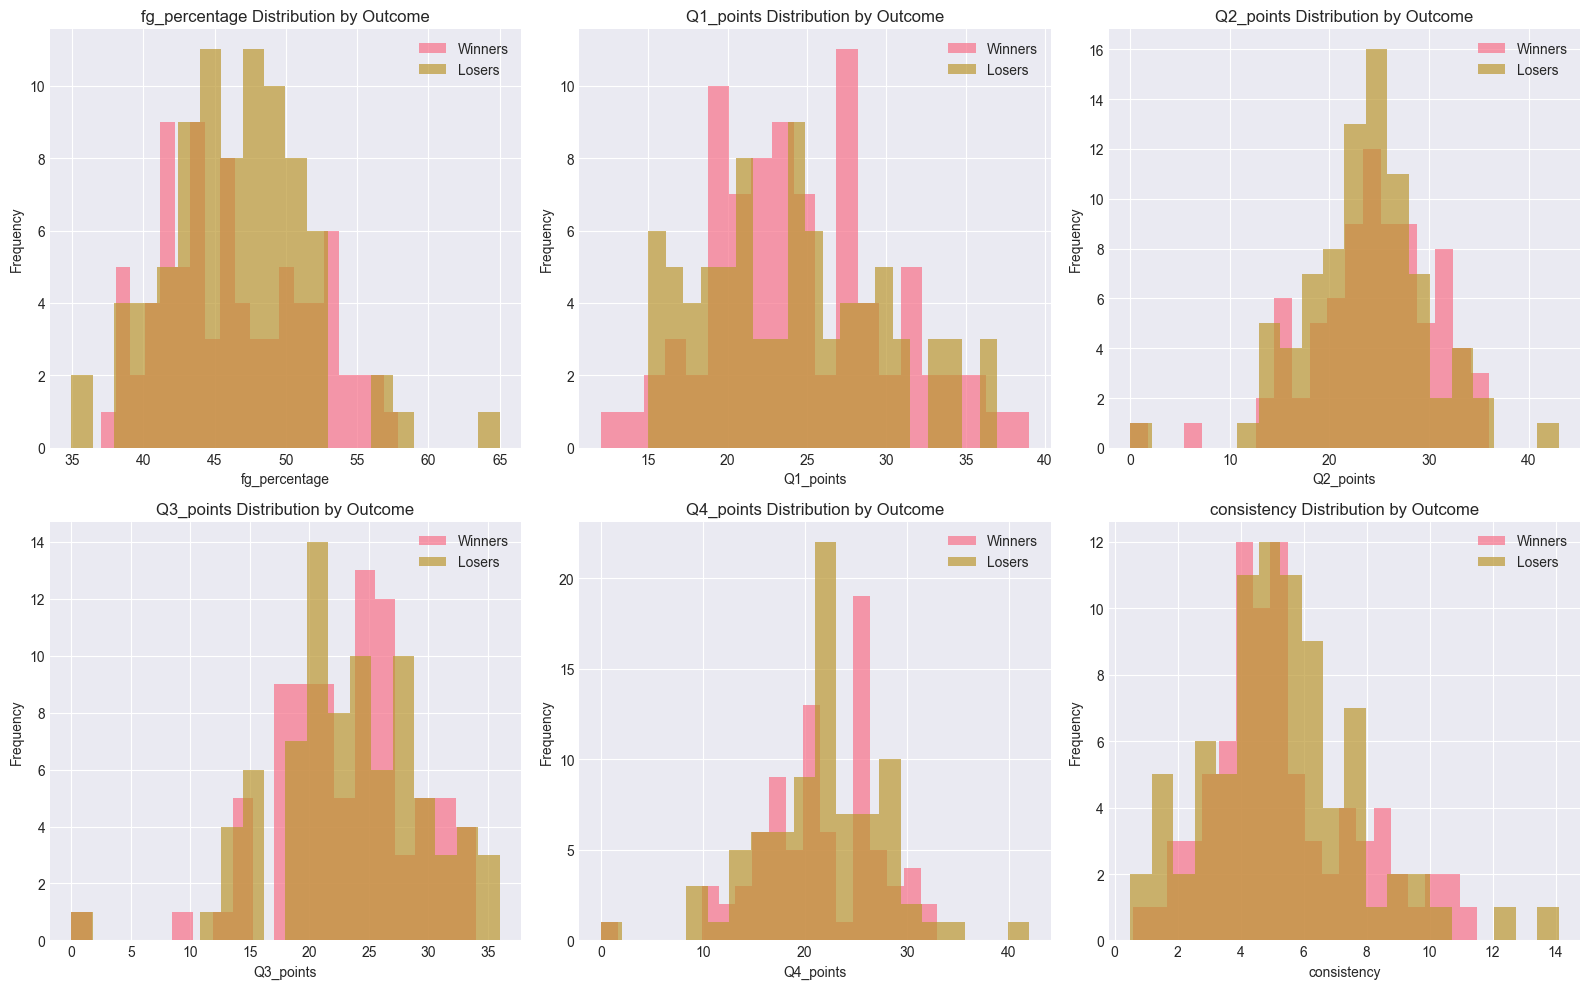


QUARTER PROGRESSION PATTERNS

Average Quarter-to-Quarter Changes:
  Q1→Q2: Winners: -0.38, Losers: -0.48
  Q2→Q3: Winners: -1.09, Losers: -0.16
  Q3→Q4: Winners: -1.62, Losers: -1.68

EDA Complete! Key insights have been generated for your prediction task.


In [17]:
# 1. Distribution of Final Scores
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Final score distribution
axes[0, 0].hist(game_df[game_df['is_winner']==1]['final_score'], alpha=0.7, label='Winners', bins=30)
axes[0, 0].hist(game_df[game_df['is_winner']==0]['final_score'], alpha=0.7, label='Losers', bins=30)
axes[0, 0].set_xlabel('Final Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Final Scores by Game Outcome')
axes[0, 0].legend()

# Field goal percentage distribution
axes[0, 1].hist(game_df[game_df['is_winner']==1]['fg_percentage'].dropna(), alpha=0.7, label='Winners', bins=30)
axes[0, 1].hist(game_df[game_df['is_winner']==0]['fg_percentage'].dropna(), alpha=0.7, label='Losers', bins=30)
axes[0, 1].set_xlabel('Field Goal Percentage')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('FG% Distribution by Game Outcome')
axes[0, 1].legend()

# Quarter points comparison
if all(col in game_df.columns for col in ['Q1_points', 'Q2_points', 'Q3_points', 'Q4_points']):
    quarter_cols = ['Q1_points', 'Q2_points', 'Q3_points', 'Q4_points']
    quarter_means = game_df.groupby('is_winner')[quarter_cols].mean()
    
    x = np.arange(len(quarter_cols))
    width = 0.35
    
    axes[0, 2].bar(x - width/2, quarter_means.loc[1], width, label='Winners', alpha=0.8)
    axes[0, 2].bar(x + width/2, quarter_means.loc[0], width, label='Losers', alpha=0.8)
    axes[0, 2].set_xlabel('Quarter')
    axes[0, 2].set_ylabel('Average Points')
    axes[0, 2].set_title('Average Points per Quarter by Game Outcome')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
    axes[0, 2].legend()

# 2. Quarter-to-Quarter Momentum
if 'h1h2_momentum_change' in game_df.columns:
    axes[1, 0].hist(game_df[game_df['is_winner']==1]['h1h2_momentum_change'].dropna(), alpha=0.7, label='Winners', bins=30)
    axes[1, 0].hist(game_df[game_df['is_winner']==0]['h1h2_momentum_change'].dropna(), alpha=0.7, label='Losers', bins=30)
    axes[1, 0].set_xlabel('Momentum Change (2nd Half - 1st Half Points)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Momentum Change Distribution by Game Outcome')
    axes[1, 0].legend()

# 3. Scoring Consistency
if 'consistency' in game_df.columns:
    axes[1, 1].hist(game_df[game_df['is_winner']==1]['consistency'].dropna(), alpha=0.7, label='Winners', bins=30)
    axes[1, 1].hist(game_df[game_df['is_winner']==0]['consistency'].dropna(), alpha=0.7, label='Losers', bins=30)
    axes[1, 1].set_xlabel('Scoring Consistency (Std Dev across Quarters)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Scoring Consistency by Game Outcome')
    axes[1, 1].legend()

# 4. Correlation heatmap for game features
numeric_cols = game_df.select_dtypes(include=[np.number]).columns
corr_matrix = game_df[numeric_cols].corr()

# Select key features for correlation
key_features = ['final_score', 'is_winner', 'fg_percentage', 'made_shots', 'fg_attempts']
key_features.extend([col for col in numeric_cols if 'Q' in col and 'points' in col][:4])
key_features.extend([col for col in numeric_cols if 'moment' in col][:4])
key_features = [f for f in key_features if f in corr_matrix.columns]

if key_features:
    sns.heatmap(corr_matrix.loc[key_features, key_features], annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, ax=axes[1, 2])
    axes[1, 2].set_title('Feature Correlations')

plt.tight_layout()
plt.show()

# 3. Quarter-by-Quarter Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Quarter scoring patterns
quarterly_scores = []
for q in range(1, 5):
    col = f'Q{q}_points'
    if col in game_df.columns:
        winner_scores = game_df[game_df['is_winner']==1][col].mean()
        loser_scores = game_df[game_df['is_winner']==0][col].mean()
        quarterly_scores.append({
            'Quarter': f'Q{q}',
            'Winners': winner_scores,
            'Losers': loser_scores,
            'Difference': winner_scores - loser_scores
        })

if quarterly_scores:
    quarterly_df = pd.DataFrame(quarterly_scores)
    
    # Quarter scores line plot
    axes[0, 0].plot(quarterly_df['Quarter'], quarterly_df['Winners'], marker='o', linewidth=2, label='Winners')
    axes[0, 0].plot(quarterly_df['Quarter'], quarterly_df['Losers'], marker='s', linewidth=2, label='Losers')
    axes[0, 0].fill_between(quarterly_df['Quarter'], quarterly_df['Losers'], quarterly_df['Winners'], alpha=0.2)
    axes[0, 0].set_xlabel('Quarter')
    axes[0, 0].set_ylabel('Average Points')
    axes[0, 0].set_title('Quarter-by-Quarter Scoring Trajectory')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Difference bar plot
    colors = ['green' if x > 0 else 'red' for x in quarterly_df['Difference']]
    axes[0, 1].bar(quarterly_df['Quarter'], quarterly_df['Difference'], color=colors, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 1].set_xlabel('Quarter')
    axes[0, 1].set_ylabel('Score Difference (Winner - Loser)')
    axes[0, 1].set_title('Winners\' Scoring Advantage by Quarter')
    axes[0, 1].grid(True, alpha=0.3)

# 4. Shot success analysis by quarter
quarter_shot_success = df.groupby(['period', 'shotResult']).size().unstack(fill_value=0)
if 'Made' in quarter_shot_success.columns:
    quarter_shot_success['shot_pct'] = (quarter_shot_success['Made'] / quarter_shot_success.sum(axis=1)) * 100
    
    axes[1, 0].plot(quarter_shot_success.index[:4], quarter_shot_success['shot_pct'].iloc[:4], 
                   marker='o', linewidth=2, color='purple')
    axes[1, 0].set_xlabel('Quarter')
    axes[1, 0].set_ylabel('Shot Success Rate (%)')
    axes[1, 0].set_title('Shot Success Rate by Quarter')
    axes[1, 0].grid(True, alpha=0.3)

# 5. Game clock analysis
df['minute_in_game'] = df['sec_elapsed_game'] / 60
late_game_shots = df[df['minute_in_game'] > 40]  # Last 8 minutes of regulation

if len(late_game_shots) > 0:
    late_game_success = late_game_shots.groupby('shotResult').size()
    if 'Made' in late_game_success.index:
        labels = ['Made', 'Missed']
        sizes = [late_game_success.get('Made', 0), late_game_success.sum() - late_game_success.get('Made', 0)]
        axes[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
        axes[1, 1].set_title('Shot Success in Final 8 Minutes')

plt.tight_layout()
plt.show()

# 6. Statistical Summary by Game Outcome
print("\n" + "="*60)
print("STATISTICAL SUMMARY BY GAME OUTCOME")
print("="*60)

winners_stats = game_df[game_df['is_winner']==1].describe()
losers_stats = game_df[game_df['is_winner']==0].describe()

print("\nWinners Statistics (Key Metrics):")
print("-"*40)
for col in ['final_score', 'fg_percentage'] + [f'Q{q}_points' for q in range(1,5) if f'Q{q}_points' in game_df.columns]:
    if col in winners_stats.columns:
        print(f"{col}:")
        print(f"  Mean (Winners): {winners_stats[col]['mean']:.2f}")
        print(f"  Mean (Losers):  {losers_stats[col]['mean']:.2f}")
        print(f"  Difference:     {winners_stats[col]['mean'] - losers_stats[col]['mean']:.2f}")
        print()

# 7. Statistical Tests
print("\n" + "="*60)
print("STATISTICAL TESTS FOR QUARTER-LEVEL DIFFERENCES")
print("="*60)

for q in range(1, 5):
    col = f'Q{q}_points'
    if col in game_df.columns:
        winner_scores = game_df[game_df['is_winner']==1][col].dropna()
        loser_scores = game_df[game_df['is_winner']==0][col].dropna()
        
        if len(winner_scores) > 0 and len(loser_scores) > 0:
            t_stat, p_value = stats.ttest_ind(winner_scores, loser_scores)
            print(f"\nQuarter {q}:")
            print(f"  T-statistic: {t_stat:.4f}")
            print(f"  P-value: {p_value:.4f}")
            print(f"  {'Significant difference' if p_value < 0.05 else 'No significant difference'} at α=0.05")

# 8. Momentum Analysis
if 'h1h2_momentum_change' in game_df.columns and 'consistency' in game_df.columns:
    print("\n" + "="*60)
    print("MOMENTUM AND CONSISTENCY ANALYSIS")
    print("="*60)
    
    print(f"\nAverage Momentum Change (2nd Half - 1st Half Points):")
    print(f"  Winners: {game_df[game_df['is_winner']==1]['h1h2_momentum_change'].mean():.2f}")
    print(f"  Losers:  {game_df[game_df['is_winner']==0]['h1h2_momentum_change'].mean():.2f}")
    
    print(f"\nAverage Scoring Consistency (Std Dev across Quarters):")
    print(f"  Winners: {game_df[game_df['is_winner']==1]['consistency'].mean():.2f}")
    print(f"  Losers:  {game_df[game_df['is_winner']==0]['consistency'].mean():.2f}")
    print(f"  (Lower std dev = more consistent scoring)")

# 9. Create a summary dataframe for model features
print("\n" + "="*60)
print("FEATURE IMPORTANCE PREVIEW")
print("="*60)

# Prepare features for modeling
feature_cols = ['fg_percentage'] + [f'Q{q}_points' for q in range(1,5) if f'Q{q}_points' in game_df.columns]
if 'h1h2_momentum_change' in game_df.columns:
    feature_cols.append('h1h2_momentum_change')
if 'consistency' in game_df.columns:
    feature_cols.append('consistency')

# Calculate point-biserial correlation with outcome
from scipy.stats import pointbiserialr

print("\nCorrelation with Game Outcome (Point-Biserial):")
print("-"*40)
for col in feature_cols:
    if col in game_df.columns:
        corr, p_value = pointbiserialr(game_df['is_winner'], game_df[col])
        print(f"{col}:")
        print(f"  Correlation: {corr:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  {'Significant' if p_value < 0.05 else 'Not significant'}")

# 10. Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

plot_cols = feature_cols[:6]  # First 6 features
for i, col in enumerate(plot_cols):
    if col in game_df.columns:
        axes[i].hist(game_df[game_df['is_winner']==1][col].dropna(), alpha=0.7, label='Winners', bins=20)
        axes[i].hist(game_df[game_df['is_winner']==0][col].dropna(), alpha=0.7, label='Losers', bins=20)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{col} Distribution by Outcome')
        axes[i].legend()

# Hide unused subplot
if len(plot_cols) < 6:
    for j in range(len(plot_cols), 6):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 11. Quarter progression patterns
print("\n" + "="*60)
print("QUARTER PROGRESSION PATTERNS")
print("="*60)

# Identify common patterns
if all(f'Q{q}_points' in game_df.columns for q in range(1,5)):
    # Calculate quarter-to-quarter changes
    game_df['Q1toQ2_change'] = game_df['Q2_points'] - game_df['Q1_points']
    game_df['Q2toQ3_change'] = game_df['Q3_points'] - game_df['Q2_points']
    game_df['Q3toQ4_change'] = game_df['Q4_points'] - game_df['Q3_points']
    
    print("\nAverage Quarter-to-Quarter Changes:")
    print(f"  Q1→Q2: Winners: {game_df[game_df['is_winner']==1]['Q1toQ2_change'].mean():.2f}, "
          f"Losers: {game_df[game_df['is_winner']==0]['Q1toQ2_change'].mean():.2f}")
    print(f"  Q2→Q3: Winners: {game_df[game_df['is_winner']==1]['Q2toQ3_change'].mean():.2f}, "
          f"Losers: {game_df[game_df['is_winner']==0]['Q2toQ3_change'].mean():.2f}")
    print(f"  Q3→Q4: Winners: {game_df[game_df['is_winner']==1]['Q3toQ4_change'].mean():.2f}, "
          f"Losers: {game_df[game_df['is_winner']==0]['Q3toQ4_change'].mean():.2f}")

print("\nEDA Complete! Key insights have been generated for your prediction task.")